In [3]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt
from urllib.request import urlretrieve
from itertools import islice
import torch
from torch import tensor
from random import random
from numba import cuda
import numpy as np

In [4]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [5]:
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [6]:
!ls -l data

total 34752
-rw-r--r--  1 joeross  staff  17051982 Nov 18 13:43 mnist.pkl.gz


In [7]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [8]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [9]:
vals = list(range(1, 15))
vals

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [10]:
list(chunks(vals, 5))

[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14]]

In [11]:
chunked = chunks(vals, 5)

In [12]:
next(chunked)

[1, 2, 3, 4, 5]

In [13]:
img01 = x_train[0]

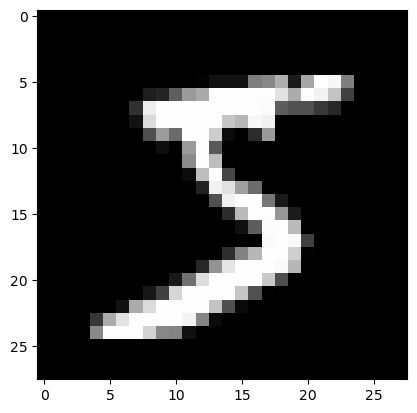

In [14]:
mpl.rcParams['image.cmap']='gray'
plt.imshow(list(chunks(img01, 28)))

In [15]:
it = iter(img01)
img = list(iter(lambda: list(islice(it, 28)), []))

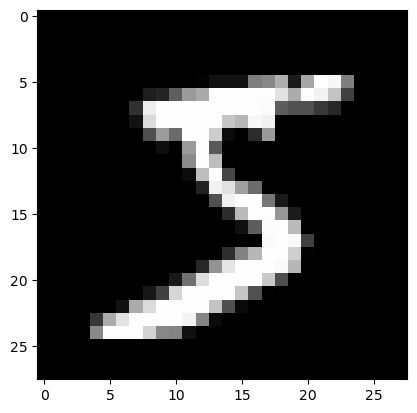

In [16]:
plt.imshow(img)

In [17]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [18]:
m = Matrix(img)
m[20,15]

0.98828125

In [19]:
tens = tensor(img)

In [20]:
tens[20,15]

tensor(0.9883)

In [21]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [22]:
x_train.type()

'torch.FloatTensor'

In [23]:
x_train.shape

torch.Size([50000, 784])

In [24]:
imgs = x_train.reshape([-1, 28, 28])

In [25]:
imgs.shape

torch.Size([50000, 28, 28])

In [26]:
imgs[0,20,15]

tensor(0.9883)

In [27]:
%timeit -n 10 list(chunks([random() for _ in range(7840)], 10))

402 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit -n 10 torch.randn(784, 10)

107 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So torch randn is definitely faster than using python random with our iter chunking method so we will use torch going forward.

## Matrix Multiplication 

In [29]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [30]:
m1 = x_valid[:5]  # Our first matrix is the first five images from our dataset
m2 = weights # The second matrix is the weights from our first nn layer

In [31]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [32]:
ar, ac = m1.shape
br, bc = m2.shape
ar, ac, br, bc # our shape info

(5, 784, 784, 10)

In [33]:
t1 = torch.zeros(ar, bc) #result matrix
t1.shape

torch.Size([5, 10])

In [34]:
for i in range(ar): # loop over 5 rows in first matrix
    for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
        for k in range(ac): # loop over the 784 values of the intersecting ac, br
            t1[i,j] += m1[i,k] * m2[k,j]

In [35]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [36]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [37]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    t1 = torch.zeros(ar, bc) #result matrix
    for i in range(ar): # loop over 5 rows in first matrix
        for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
            for k in range(ac): # loop over the 784 values of the intersecting ac, br
                t1[i,j] += m1[i,k] * m2[k,j]
    return t1

In [38]:
%time _=matmul(m1, m2)

CPU times: user 546 ms, sys: 3.9 ms, total: 550 ms
Wall time: 550 ms


> This is a little slow...

In [39]:
from numba import njit
# this annotation will cause this function to be compiled to machine code the first time it is run
@njit
def dot(a,b): 
    res = 0.
    for i in range(len(a)): res+=a[i] * b[i]
    return res

In [40]:
from numpy import array

In [41]:
%time dot(array([1.,2,3]), array([2.,3,4]))

CPU times: user 237 ms, sys: 54.8 ms, total: 292 ms
Wall time: 2.46 s


20.0

In [42]:
%time dot(array([1.,2,3]), array([2.,3,4]))

CPU times: user 18 µs, sys: 1 µs, total: 19 µs
Wall time: 21 µs


20.0

time is way down after initial compile!

In [43]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    t1 = torch.zeros(ar, bc) #result matrix
    for i in range(ar): # loop over 5 rows in first matrix
        for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
            t1[i,j] = dot(a[i, :], b[:, j])
    return t1

In [44]:
from fastcore.test import *

In [45]:
m1a, m2a = m1.numpy(), m2.numpy()

In [46]:
test_close(t1, matmul(m1a, m2a))

In [47]:
%timeit -n 50 matmul(m1a, m2a)

301 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


> much faster!!!

## Elementwise operations

In [48]:
a = tensor([10., 6, 4])
b = tensor([2., 8, 7])
a + b

tensor([12., 14., 11.])

In [49]:
(a<b).float()

tensor([0., 1., 1.])

In [50]:
(a<b).float().mean()

tensor(0.67)

In [51]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [52]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc) #result matrix
    for i in range(ar): # loop over 5 rows in first matrix
        for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c
    

In [53]:
test_close(t1, matmul(m1,m2))

In [54]:
%timeit -n 50 _=matmul(m1, m2)

671 µs ± 8.37 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

In [55]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [56]:
c = tensor([10,20,30])
c

tensor([10, 20, 30])

In [57]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [58]:
m+c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

> This is super cool, you can see how the matrix will be expanded to perform elementwise ops on the target size

In [59]:
t = c.expand_as(m)
t

tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])

> two ways to insert axis

In [60]:
c.unsqueeze(0), c[None,:]

(tensor([[10, 20, 30]]), tensor([[10, 20, 30]]))

In [61]:
c.unsqueeze(1), c[:, None]

(tensor([[10],
         [20],
         [30]]),
 tensor([[10],
         [20],
         [30]]))

In [62]:
c[:, None].expand_as(m)

tensor([[10, 10, 10],
        [20, 20, 20],
        [30, 30, 30]])

In [63]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [64]:
c.shape

torch.Size([3])

In [65]:
c[:,None] * c[None,:]

tensor([[100, 200, 300],
        [200, 400, 600],
        [300, 600, 900]])

In [66]:
c * c[None,:]

tensor([[100, 400, 900]])

## Matrix multiplication with broadcasting

In [67]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [68]:
m1[0].shape,m1[0][:, None].shape

(torch.Size([784]), torch.Size([784, 1]))

In [69]:
m1[:,None]


tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

In [70]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc) #result matrix
    for i in range(ar): # loop over 5 rows in first matrix
       c[i] = (a[i, :, None] * b).sum(dim=0)
    return c
    

In [71]:
test_close(t1, matmul(m1, m2))

In [72]:
%timeit -n 50 _=matmul(m1, m2)

75.4 µs ± 5.38 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [73]:
tr = matmul(x_train, weights)
tr.shape

torch.Size([50000, 10])

## Einstein summation

einsum is a way of describing products and sums.  Each letter is an axis, axis with the same letter get multiplied, axis removed get summed. Here you can see the first with the additional sum is equivilent to the second.  Both give the result of dot product.

In [74]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [75]:
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [76]:
mr.sum(1).shape

torch.Size([5, 10])

In [77]:
torch.einsum('ik,kj->ij', m1, m2).shape

torch.Size([5, 10])

In [78]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [79]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [80]:
%timeit -n 5 _=matmul(x_train, weights)

18.8 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Native pytorch

In [81]:
test_close(tr, x_train@weights, eps=1e-3)
%timeit -n 5 _=torch.matmul(x_train, weights)

17 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Basically the same speed as einsum, done natively with the `@` symbol

## Cuda support

In [82]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [83]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))
r.shape

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [ ]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [ ]:
matmul[blockspergrid, (TPB,TPB)](m1g, m2g, rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [ ]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

9.24 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
m1c, m2c = x_train.cuda(), weights.cuda()

In [ ]:
r = (m1c@m2c).cpu()
test_close(tr, r)

In [ ]:
%timeit -n 100 r=(m1c@m2c).cpu()

1.18 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Signature: test_close(a, b, eps=1e-05)
Source:   
def test_close(a,b,eps=1e-5):
    "`test` that `a` is within `eps` of `b`"
    test(a,b,partial(is_close,eps=eps),'close')
File:      ~/mambaforge/envs/fastai/lib/python3.11/site-packages/fastcore/test.py
Type:      function